In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2, DenseNet169, InceptionV3
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
data_dir = '/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN Md. Amir Khasru.zip'

In [ ]:
# Step 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Step 2: Define paths and verify the ZIP file exists
import os

# Path to your ZIP file (update if needed)
zip_path = '/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN Md. Amir Khasru.zip'

# Check if the file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at: {zip_path}")
else:
    print("ZIP file found!")

# Step 3: Extract the ZIP file
import zipfile

# Where to extract the files (customize if needed)
extract_dir = '/content/drive/MyDrive/Defense /DataSet'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract all files (handles password-protected ZIPs if needed)
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully extracted to: {extract_dir}")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or is corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")

# Step 4: List extracted files (verify extraction)
extracted_files = os.listdir(extract_dir)
print("\nExtracted files/folders:")
for file in extracted_files:
    print(f"- {file}")

# Step 5: Example - Load a CSV file (if your data includes one)
import pandas as pd

# Replace 'your_data.csv' with your actual filename
csv_path = os.path.join(extract_dir, 'your_data.csv')

if os.path.exists(csv_path):
    print("\nLoading CSV file...")
    df = pd.read_csv(csv_path)
    print(df.head())
else:
    print("\nNo CSV file found in the extracted data. Here's what's available:")
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (1).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (10).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (100).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (1000).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (101).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (102).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (103).jpg
/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025/Downy Mildew Diease/Downy Mildew Diease (104).jpg
/content/drive/

In [ ]:
data_dir = '/content/drive/MyDrive/Defense /DataSet/DATA of SWEET PUMPKIN 2025'
keyword=['Downy Mildew Diease','Fresh Leaf','Leaf Curl Diease','Mosaic Diease','Red beetle Diease']
labels_dict = {
    'Downy Mildew Diease': 1, 'Fresh Leaf': 2,
    'Leaf Curl Diease': 3, 'Mosaic Diease': 4,'Red beetle Diease': 5
}

class_folders = os.listdir(data_dir)
image_paths = []
labels = []
for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
            class_path = os.path.join(data_dir, class_folder)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [ ]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['Downy Mildew Diease' 'Fresh Leaf' 'Leaf Curl Diease' 'Mosaic Diease'
 'Red beetle Diease']


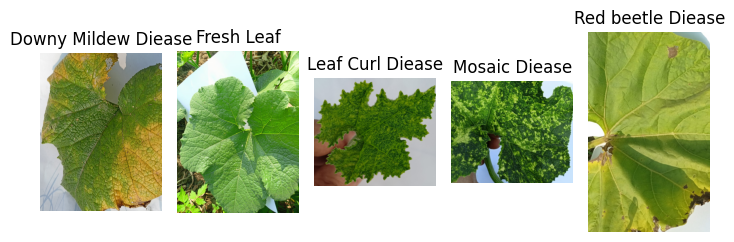

In [ ]:
num_classes = len(df['label'].unique())

num_images_per_row = 5
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(7, 3 * num_rows))

for i, new_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    path = os.path.join(data_dir, df[df['label'] == new_class]['image_path'].iloc[0])

    if os.path.exists(path):
        sample_image = cv2.imread(path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(new_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {path}")
    else:
        print(f"Error: Image path does not exist: {path}")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, rest_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [ ]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224)):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


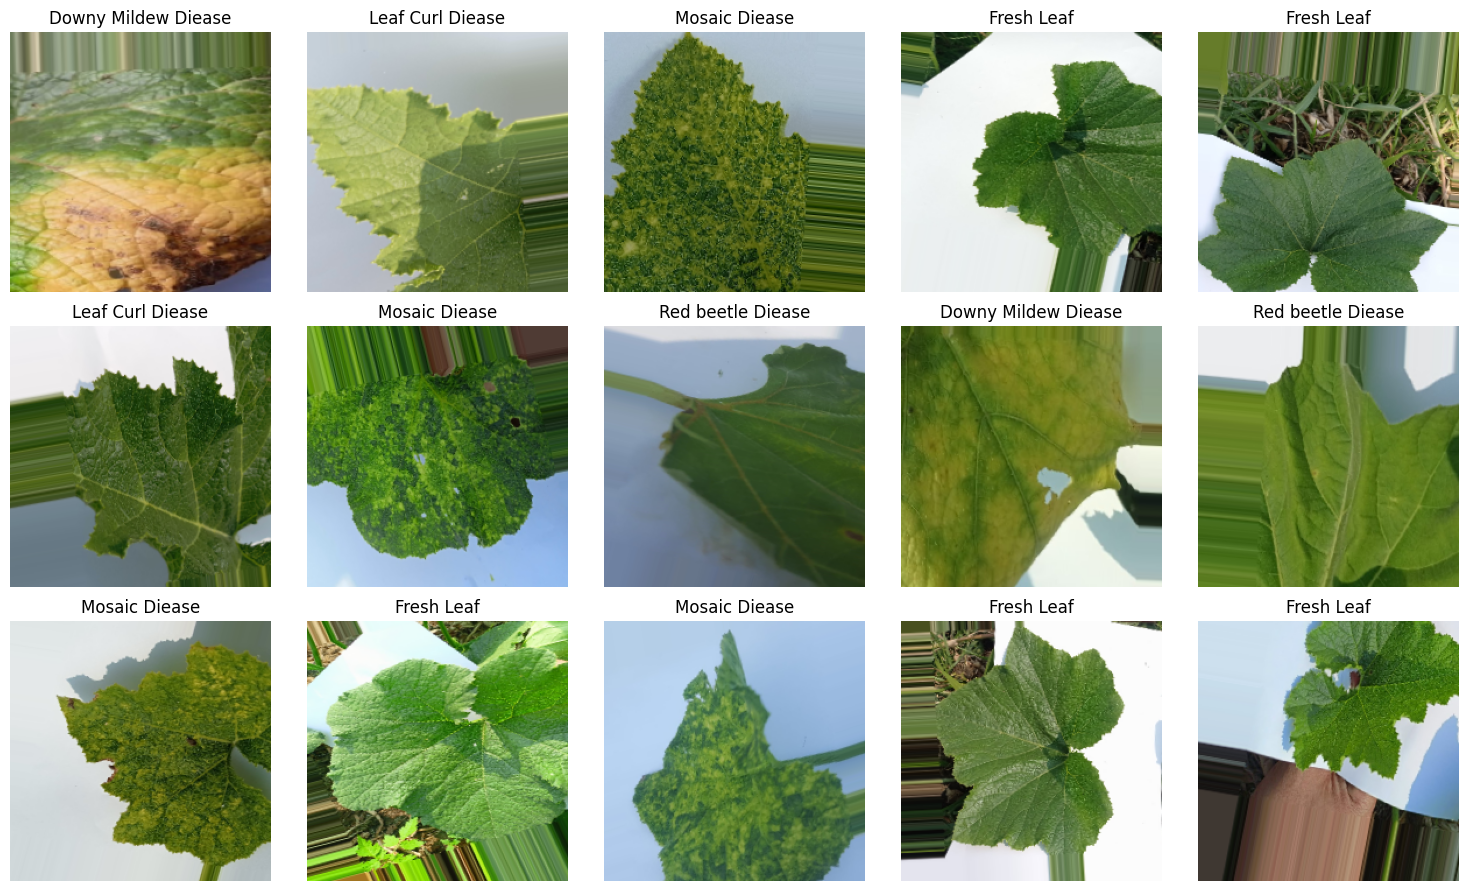

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_preprocessed_images(data_generator, class_indices, num_images=10):

    images, labels = next(data_generator)  # Get a batch of images and labels
    labels = np.argmax(labels, axis=1)  # Convert one-hot labels to class indices
    class_names = {v: k for k, v in class_indices.items()}  # Reverse the class_indices mapping

    # Determine the number of rows and columns for the plot
    num_images = min(num_images, len(images))
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])  # Images are already normalized
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with the train generator
train_generator, validation_generator, test_generator = load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224))
show_preprocessed_images(train_generator, train_generator.class_indices, num_images=15)


### DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
DenseNet121 = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)
DenseNet121.trainable = False
model_DenseNet = tf.keras.models.Sequential([
    DenseNet121,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='softmax'),
])
model_DenseNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_DenseNet = model_DenseNet.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=5
)
test_loss, test_accuracy = model_DenseNet.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1430s 11s/step - accuracy: 0.5852 - loss: 5.4728 - val_accuracy: 0.8520 - val_loss: 0.4520
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1430s 11s/step - accuracy: 0.8005 - loss: 0.5700 - val_accuracy: 0.8340 - val_loss: 0.3465
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1430s 11s/step - accuracy: 0.8273 - loss: 0.4633 - val_accuracy: 0.8980 - val_loss: 0.2733
Epoch 4/5
107/125 ━━━━━━━━━━━━━━━━━━━━ 3:04 10s/step - accuracy: 0.8323 - loss: 0.4437

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_DenseNet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels = ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
                     precision    recall  f1-score   support

Downy Mildew Diease       1.00      0.96      0.98       108
         Fresh Leaf       0.90      0.94      0.92        94
   Leaf Curl Diease       0.81      0.80      0.81        96
      Mosaic Diease       0.90      0.90      0.90       107
  Red beetle Diease       0.96      0.97      0.96        95

           accuracy                           0.91       500
          macro avg       0.91      0.91      0.91       500
       weighted avg       0.91      0.91      0.91       500



<Axes: >

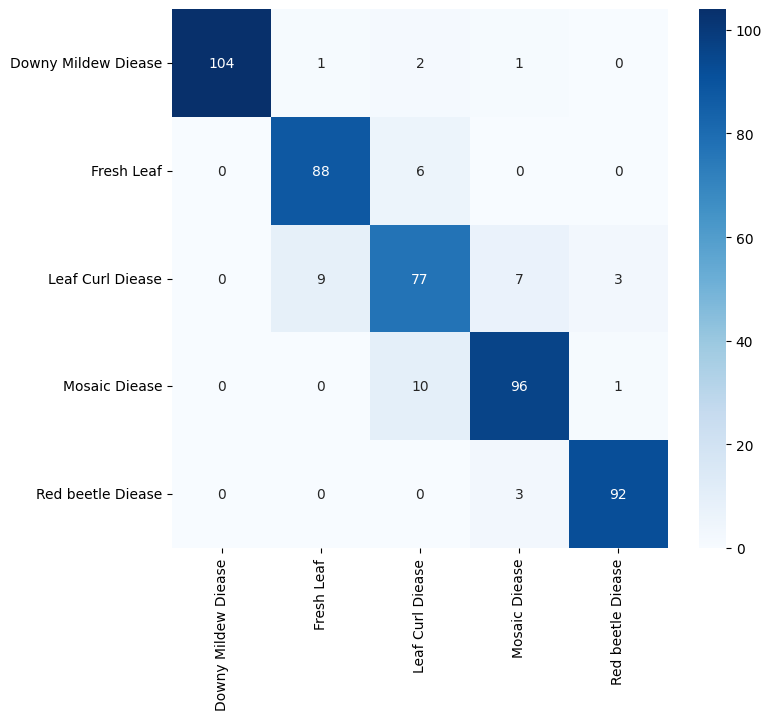

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']],
                  columns = [i for i in  ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, fmt='d',  cmap='Blues')

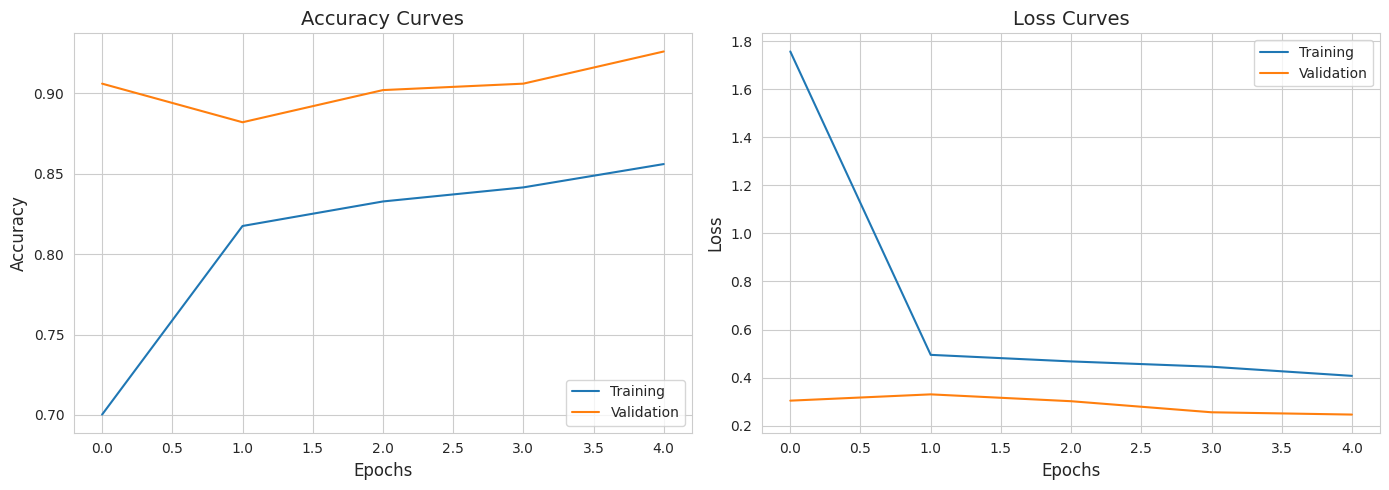

In [ ]:
import seaborn as sns
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

# Accuracy plot
plt.subplot(1, 2, 1)
sns.lineplot(data=history_DenseNet.history['accuracy'], label='Training')
sns.lineplot(data=history_DenseNet.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
sns.lineplot(data=history_DenseNet.history['loss'], label='Training')
sns.lineplot(data=history_DenseNet.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()

### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )
VGG16.trainable = False
model_vgg16 = tf.keras.models.Sequential([
  VGG16,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'),
])
model_vgg16.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
history_vgg16 = model_vgg16.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs = 5
)
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4886 - loss: 2.2123 - val_accuracy: 0.8520 - val_loss: 0.4319
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7397 - loss: 0.6972 - val_accuracy: 0.8500 - val_loss: 0.4053
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7589 - loss: 0.6522 - val_accuracy: 0.8840 - val_loss: 0.3146
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7623 - loss: 0.6298 - val_accuracy: 0.8560 - val_loss: 0.3535
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7918 - loss: 0.5684 - val_accuracy: 0.8820 - val_loss: 0.3294
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - accuracy: 0.8857 - loss: 0.3786
Test Loss: 0.3777153491973877, Test Accuracy: 0.8759999871253967


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_vgg16.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 656ms/step
                     precision    recall  f1-score   support

Downy Mildew Diease       0.84      0.94      0.89       108
         Fresh Leaf       0.94      0.82      0.88        94
   Leaf Curl Diease       0.79      0.80      0.79        96
      Mosaic Diease       0.93      0.88      0.90       107
  Red beetle Diease       0.90      0.93      0.91        95

           accuracy                           0.88       500
          macro avg       0.88      0.87      0.88       500
       weighted avg       0.88      0.88      0.88       500



<Axes: >

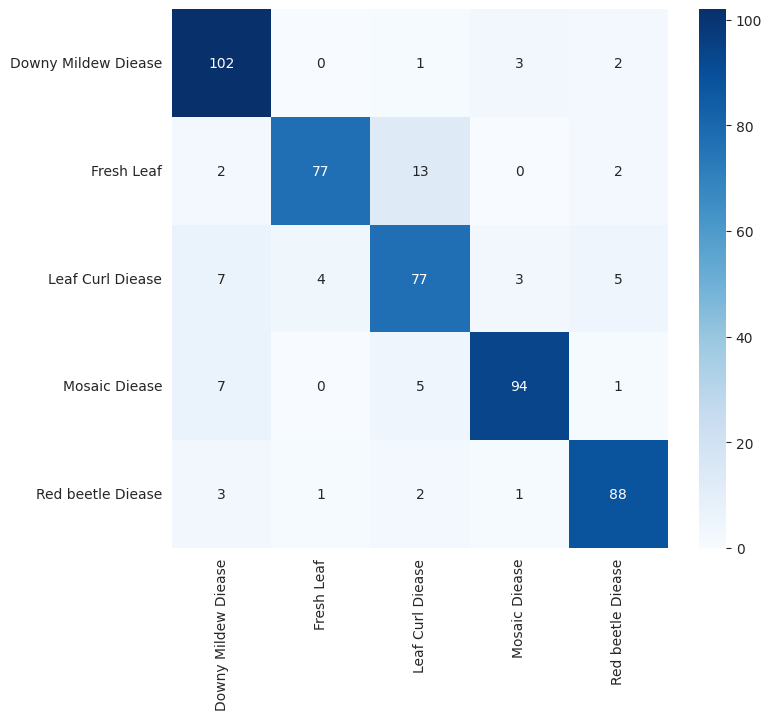

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in  ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']],
                  columns = [i for i in  ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, fmt='d',  cmap='Blues')

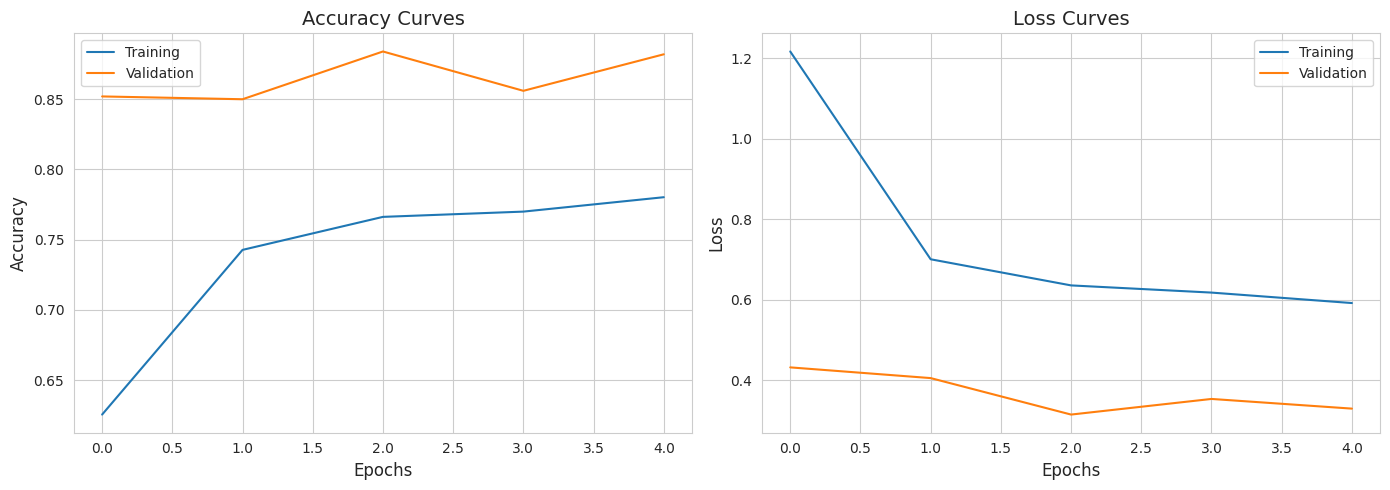

In [ ]:

import seaborn as sns
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

# Accuracy plot
plt.subplot(1, 2, 1)
sns.lineplot(data=history_vgg16.history['accuracy'], label='Training')
sns.lineplot(data=history_vgg16.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
sns.lineplot(data=history_vgg16.history['loss'], label='Training')
sns.lineplot(data=history_vgg16.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()

### VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )
VGG19.trainable = False
model_vgg19 = tf.keras.models.Sequential([
  VGG19,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'),
])
model_vgg19.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
history_vgg19 = model_vgg19.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs = 5
)
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4593 - loss: 2.6843 - val_accuracy: 0.8080 - val_loss: 0.5395
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6986 - loss: 0.7957 - val_accuracy: 0.8020 - val_loss: 0.4985
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7272 - loss: 0.7105 - val_accuracy: 0.8600 - val_loss: 0.4172
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7660 - loss: 0.6454 - val_accuracy: 0.8700 - val_loss: 0.4225
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7475 - loss: 0.6528 - val_accuracy: 0.8520 - val_loss: 0.3861
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 631ms/step - accuracy: 0.8377 - loss: 0.4568
Test Loss: 0.4248040020465851, Test Accuracy: 0.8500000238418579


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_vgg19.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 671ms/step
                     precision    recall  f1-score   support

Downy Mildew Diease       0.92      0.82      0.87       108
         Fresh Leaf       0.81      0.88      0.85        94
   Leaf Curl Diease       0.71      0.79      0.75        96
      Mosaic Diease       0.90      0.82      0.86       107
  Red beetle Diease       0.93      0.94      0.93        95

           accuracy                           0.85       500
          macro avg       0.85      0.85      0.85       500
       weighted avg       0.86      0.85      0.85       500



<Axes: >

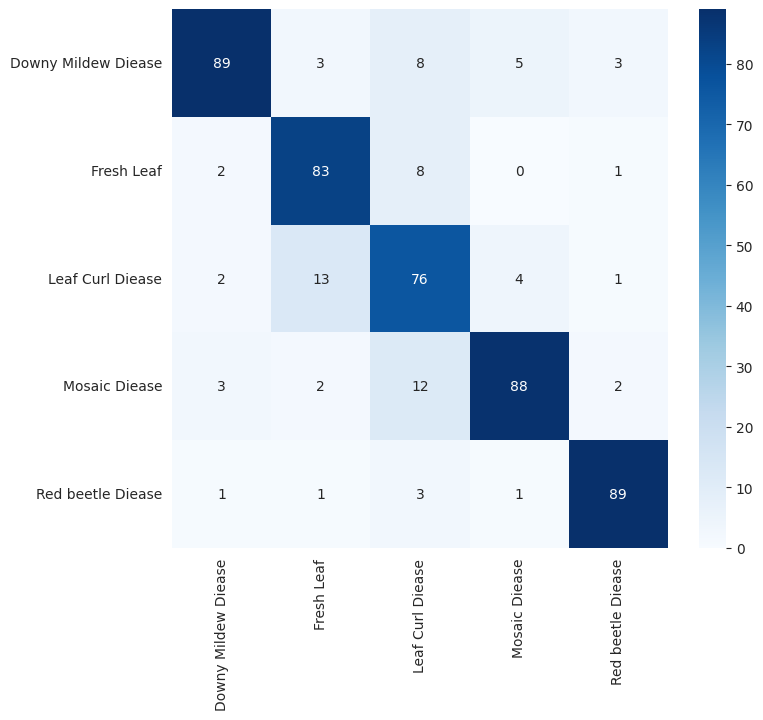

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in  ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']],
                  columns = [i for i in   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, fmt='d',  cmap='Blues')

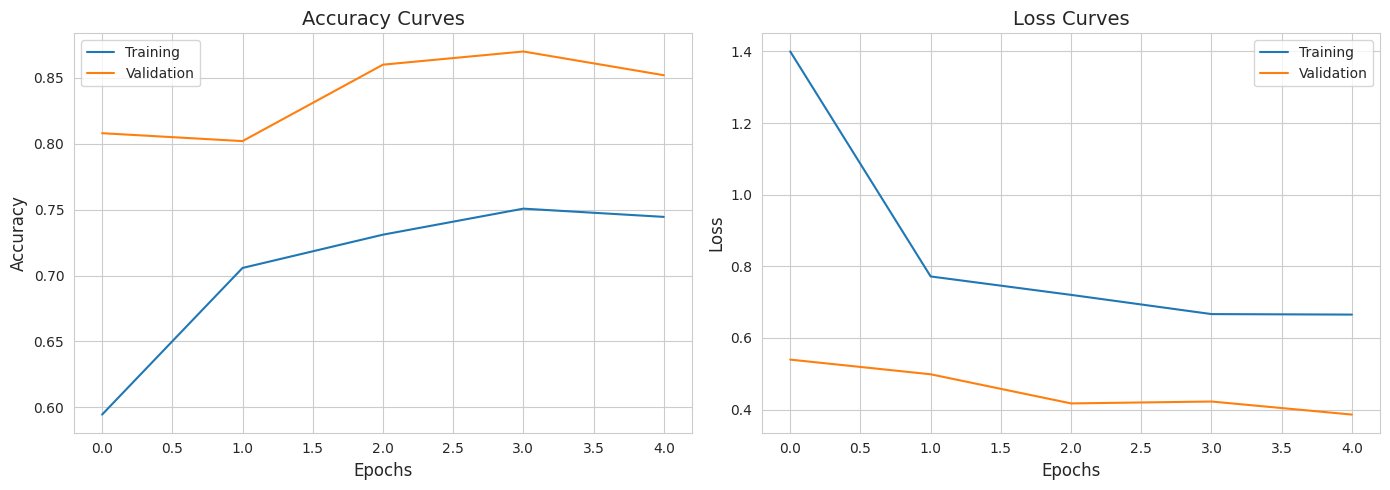

In [ ]:

import seaborn as sns
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

# Accuracy plot
plt.subplot(1, 2, 1)
sns.lineplot(data=history_vgg19.history['accuracy'], label='Training')
sns.lineplot(data=history_vgg19.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
sns.lineplot(data=history_vgg19.history['loss'], label='Training')
sns.lineplot(data=history_vgg19.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()


### MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet
MobileNetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )
MobileNetv2.trainable = False
model_MobileNetV2 = tf.keras.models.Sequential([
  MobileNetv2,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'),
])
model_MobileNetV2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
history_MobileNetV2 = model_MobileNetV2.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=5
)
test_loss, test_accuracy = model_MobileNetV2.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5711 - loss: 6.3464 - val_accuracy: 0.8900 - val_loss: 0.3211
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8153 - loss: 0.4992 - val_accuracy: 0.8720 - val_loss: 0.3259
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8403 - loss: 0.4407 - val_accuracy: 0.9280 - val_loss: 0.2123
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8488 - loss: 0.4193 - val_accuracy: 0.9380 - val_loss: 0.2101
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8565 - loss: 0.3696 - val_accuracy: 0.9260 - val_loss: 0.2592
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 636ms/step - accuracy: 0.9068 - loss: 0.2597
Test Loss: 0.23749005794525146, Test Accuracy: 0.9139999747276306


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_MobileNetV2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 792ms/step
                     precision    recall  f1-score   support

Downy Mildew Diease       0.92      0.98      0.95       108
         Fresh Leaf       0.98      0.86      0.92        94
   Leaf Curl Diease       0.81      0.90      0.85        96
      Mosaic Diease       0.91      0.86      0.88       107
  Red beetle Diease       0.97      0.97      0.97        95

           accuracy                           0.91       500
          macro avg       0.92      0.91      0.91       500
       weighted avg       0.92      0.91      0.91       500



<Axes: >

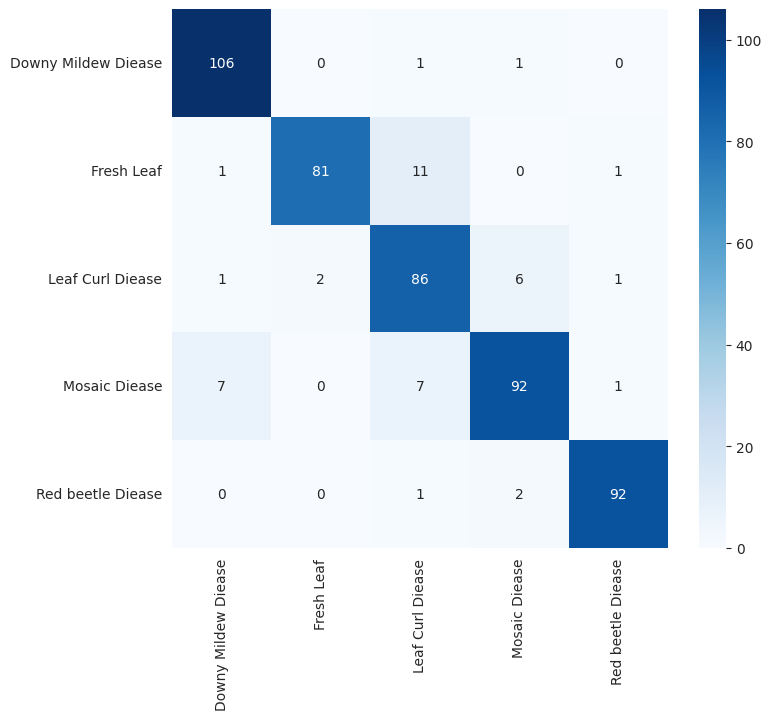

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']],
                  columns = [i for i in   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, fmt='d',  cmap='Blues')

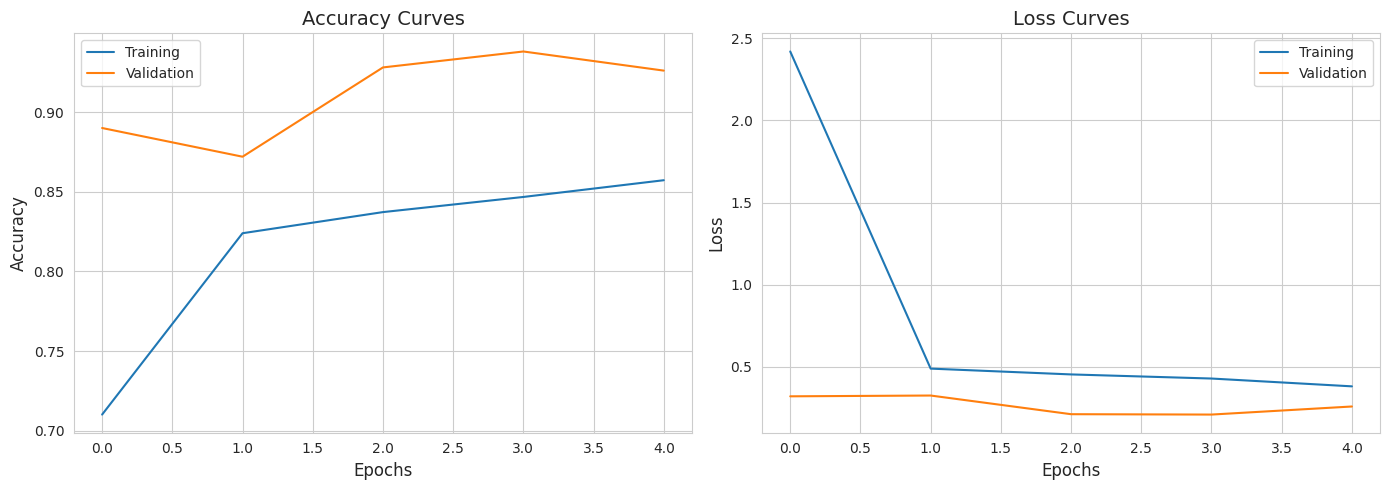

In [ ]:

import seaborn as sns
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

# Accuracy plot
plt.subplot(1, 2, 1)
sns.lineplot(data=history_MobileNetV2.history['accuracy'], label='Training')
sns.lineplot(data=history_MobileNetV2.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
sns.lineplot(data=history_MobileNetV2.history['loss'], label='Training')
sns.lineplot(data=history_MobileNetV2.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()


### InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = 'imagenet',
    input_shape=(224,224,3),
    )
InceptionV3.trainable = False
model_InceptionV3 = tf.keras.models.Sequential([
  InceptionV3,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'),
    ])
model_InceptionV3.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
history_InceptionV3 = model_InceptionV3.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs = 5
)
test_loss, test_accuracy = model_InceptionV3.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.4872 - loss: 10.8150 - val_accuracy: 0.8540 - val_loss: 0.4244
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7674 - loss: 0.6136 - val_accuracy: 0.8440 - val_loss: 0.4546
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7635 - loss: 0.6155 - val_accuracy: 0.8520 - val_loss: 0.4368
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7998 - loss: 0.5403 - val_accuracy: 0.8840 - val_loss: 0.3581
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8259 - loss: 0.4771 - val_accuracy: 0.8920 - val_loss: 0.3196
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 656ms/step - accuracy: 0.8530 - loss: 0.3581
Test Loss: 0.34161484241485596, Test Accuracy: 0.8640000224113464


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_InceptionV3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 983ms/step
                     precision    recall  f1-score   support

Downy Mildew Diease       0.96      0.88      0.92       108
         Fresh Leaf       0.95      0.76      0.84        94
   Leaf Curl Diease       0.70      0.84      0.76        96
      Mosaic Diease       0.82      0.88      0.85       107
  Red beetle Diease       0.95      0.96      0.95        95

           accuracy                           0.86       500
          macro avg       0.88      0.86      0.87       500
       weighted avg       0.88      0.86      0.87       500



<Axes: >

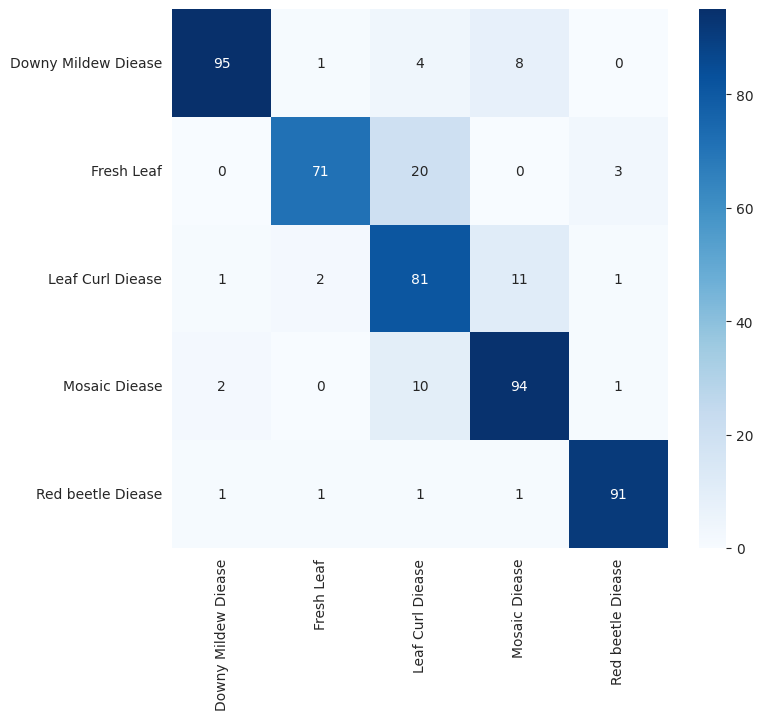

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in   ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']],
                  columns = [i for i in  ['Downy Mildew Diease', 'Fresh Leaf', 'Leaf Curl Diease', 'Mosaic Diease','Red beetle Diease']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, fmt='d',  cmap='Blues')

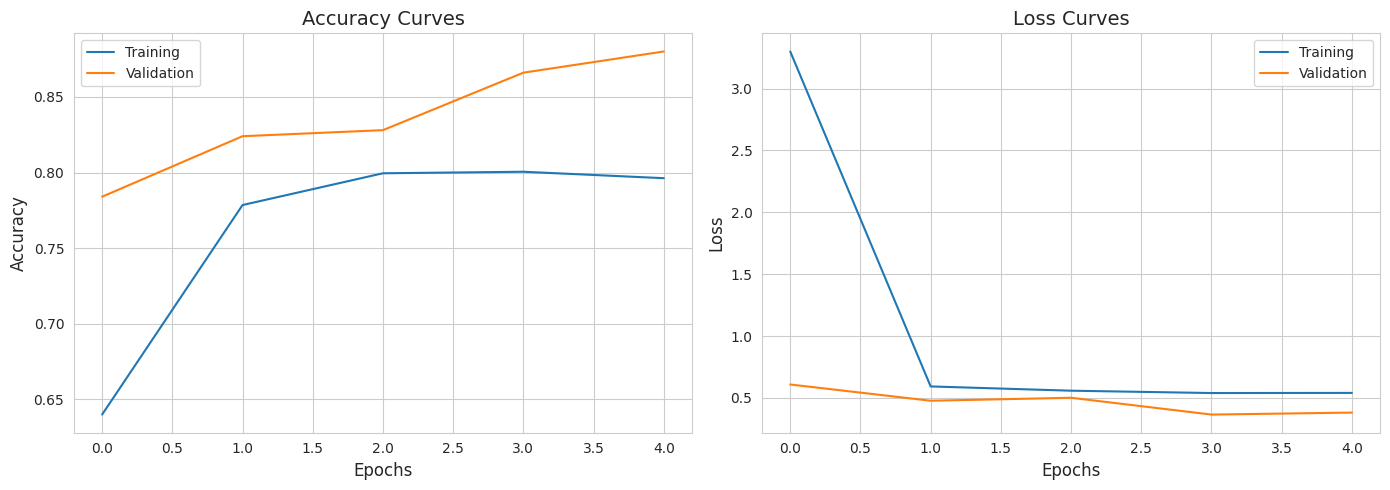

In [ ]:

import seaborn as sns
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

# Accuracy plot
plt.subplot(1, 2, 1)
sns.lineplot(data=history_InceptionV3.history['accuracy'], label='Training')
sns.lineplot(data=history_InceptionV3.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
sns.lineplot(data=history_InceptionV3.history['loss'], label='Training')
sns.lineplot(data=history_InceptionV3.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model to an HDF5 file
model_MobileNetV2.save('/content/drive/MyDrive/Defense/best_model.h5')